In [10]:
from fastai.vision import *
from fastai.metrics import error_rate, dice, accuracy
import os
import boto3

In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
client = boto3.client('s3')

# Copy the data from a Kaggle competition to S3

### I tried using Kaggle CLI to upload the data directly to AWS but it failed eventually!

In AWS, open a terminal, for example from a SageMaker notebook instance jupyter lab and install Kaggle CLI:<br>
$\;\;\;\;\;$ pip install kaggle<br>
Go to your kaggle account, make an API token<br>
In AWS local instance, make a file with path and name /home/ec2-user/.kaggle/kaggle.json with the token content:<br>
$\;\;\;\;\;$ nano .kaggle/kaggle.json (do so by nano or vim or any text editor you like, copy from there and paste here)<br> 
$\;\;\;\;\;$ chmod 0600 kaggle.json (make it unreadable for others) <br>

Now you can run kaggle api commands (CLI): <br>
$\;\;\;\;\;$ kaggle competitions list (this should list all competitions)<br>
$\;\;\;\;\;$ kaggle competitions files name-of-your-competition (have a look at the files of the competition you are interested in) <br>
$\;\;\;\;\;$ kaggle competitions download -p local-folder-for-your-data name-of-your-competition (this should download all those files for you)<br>

Error: ran out of space!! Even though I increased the instance space size to 150G. The data was 100G

### so I downloaded the data to my computer and uploaded it to AWS S3 by AWS CLI 

First I installed AWS CLI:<br>
$\;\;\;\;\;$ pip3 install --upgrade --user awscli<br>
$\;\;\;\;\;$ (note: I needed to add the path “/Users/mojgan/.local/bin”, where aws was installed, to PATH)<br>
I made a user in AWS IAM, and created an access key for it. I downloaded the generated csv file instantly.
Then I created a credentials file in ~/.aws and copied the information from the downloaded csv file into it, with the following format: <br>
$\;\;\;\;\;$ [default] <br>
$\;\;\;\;\;$ aws_access_key_id = your_access_key_id <br>
$\;\;\;\;\;$ aws_secret_access_key = your_secret_access_key <br>

Now do the copy (does not copy a whole folder, so it has to be a zip file if there are many files)<br>
$\;\;\;\;\;$aws s3 cp local-path-to-file/my-file.zip s3://my-bucket-name/prefix-or-folder-name/

### write a bucket policy, to give access to your IAM role

For having access to my s3 bucket from my notebook, I had to write a policy for my user role and my bucket:

```
{
    "Version": "...",
    "Id": "...",
    "Statement": [
        {
            "Sid": "...",
            "Effect": "Allow",
            "Principal": {
                "AWS": "arn:aws:iam::..."
            },
            "Action": "s3:*",
            "Resource": "arn:aws:s3:::my-bucket-name/*"
        }
    ]
}
```
Action s3:* allowes everything on the named s3 bucket. 


If you do not have this /* at the end of your bucket name, it does not give you access to the files in the bucket. You would only have access to list the things that are in the bucket. But with /* the problem is fixed

### The following helps with making s3 paths and listing, uploading and downloading files

```python
region = boto3.Session().region_name
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,'my-bucket-name')
file_path = 'https://s3-{}.amazonaws.com/{}{}'.format(region,'my-bucket-name', 'key')
```

list all files in a bucket (with automatic paginating I assume)
```python
bucket=boto3.Session().resource('s3').Bucket('my-bucket-name')
  for obj in bucket.objects.all():
     print(obj.key)
```

list all files (up to 1000, I have set it to 100 here) with a prefix (in a folder) in the bucket. We need boto3 client for this, rather than resource
```python
s3 = boto3.client("s3")
response = s3.list_objects_v2(
        Bucket="my-bucket-name",
        Prefix ='prefix',
        MaxKeys=100 )
if(response['KeyCount']>0)
  for content in response['Contents']:
      print(content['Key'])
```
we can also do the following for each content, and get the object and print the body or the last modified date
```python
obj_dict = client.get_object(Bucket='my-bucket-name', Key=content['Key'])
    print(content['Key'], obj_dict['LastModified'])
```

uses paginator to count all files with a prefix in the bucket, and do something with the files
```python
client = boto3.client('s3')
paginator = client.get_paginator('list_objects_v2')
page_iterator = paginator.paginate(Bucket='my-bucket-name', Prefix ='prefix')
for page in page_iterator:
    print(len(page['Contents']))
    for content in page['Contents']:
        #do what ever you want with content 
```

upload file 
```python 
s3_client = boto3.client('s3')
s3_client.upload_file(
    file_name, 
    Bucket="my-bucket-name",
    Key='prefix/filename'
)
```

upload file object
```python 
s3_client = boto3.client('s3')
with open("FILE_NAME", "rb") as file_object: 
    # file must be open in binary mode (rb is read access and binary mode)
    s3_client.upload_fileobj(
    file_object,
    Bucket="my-bucket-name",
    Key='prefix/filename'
)
```

copy a file from s3 to s3
```python
s3_resource = boto3.resource("s3")
copy_source = {
    'Bucket': 'my-bucket-name',
    'Key': 'prefix/my-file'
}
s3_resource.Object("my-bucket-name", 'prefix/new-file').copy_from(
 CopySource=copy_source)
```

download a file from s3 to local space
```python
client = boto3.client('s3')
client.download_file(Bucket='my-bucket-name', Key='key', Filename='local-path/file-name')
```

delete a file from s3
```python
s3_resource.Object('my-bucket-name', 'prefix/my-file').delete()
```

### test local file reading and s3 reading for comparison. 300 files, 28ms vs 11s. That is 400 times slower!

I first tried using boto3 to access files on s3 for the whole training process. It was quite slow, so I tried copying the data on the instance ECS (looks like a local copy but apparently it is not exactly local). I noticed that the trainig job is not any faster. So, maybe for this small set of images, the data was cached, therefore it is faster. It is mentioned in AWS documents that ECS is no faster than S3 as ECS also uses network for data transfer.

In [77]:
%%time
for i in range(100):
    obj_dict = client.get_object(Bucket='my-bucket-name', Key="key1")
    obj_dict = client.get_object(Bucket='my-bucket-name', Key="key2")
    obj_dict = client.get_object(Bucket='my-bucket-name', Key="key3")

CPU times: user 3.83 s, sys: 129 ms, total: 3.96 s
Wall time: 10.8 s


In [76]:
%%time
for i in range(100):
    f = open("file1", "rb")
    f.read()
    f = open("file2", "rb")
    f.read()
    f = open("file3", "rb")
    f.read()

CPU times: user 4.54 ms, sys: 23.8 ms, total: 28.3 ms
Wall time: 27.8 ms


# Unzip the data in S3, and zip the results in S3

In [6]:
# The following code (class S3File) is copied from https://alexwlchan.net/2019/02/working-with-large-s3-objects/
# thanks to Alex Chan
import io
class S3File(io.RawIOBase):
    def __init__(self, s3_object):
        self.s3_object = s3_object
        self.position = 0

    def seek(self, offset, whence=io.SEEK_SET):
        if whence == io.SEEK_SET:
            self.position = offset
        elif whence == io.SEEK_CUR:
            self.position += offset
        elif whence == io.SEEK_END:
            self.position = self.s3_object.content_length + offset
        else:
            raise ValueError("invalid whence (%r, should be %d, %d, %d)" % (
                whence, io.SEEK_SET, io.SEEK_CUR, io.SEEK_END
            ))

        return self.position

    def seekable(self):
        return True

    @property
    def size(self):
        return self.s3_object.content_length

    def read(self, size=-1):
        if size == -1:
            # Read to the end of the file
            range_header = "bytes=%d-" % self.position
            self.seek(offset=0, whence=io.SEEK_END)
        else:
            new_position = self.position + size

            # If we're going to read beyond the end of the object, return
            # the entire object.
            if new_position >= self.size:
                return self.read()

            range_header = "bytes=%d-%d" % (self.position, new_position - 1)
            self.seek(offset=size, whence=io.SEEK_CUR)

        return self.s3_object.get(Range=range_header)["Body"].read()

    def readable(self):
        return True

In [ ]:
#don't do again. This unzips the data.
import boto3
import zipfile
from io import BytesIO
s3_resource = boto3.resource('s3')
zip_obj = s3_resource.Object(bucket_name="my-bucket-name", key='prefix/my-file.zip')
s3_file = S3File(zip_obj)
z = zipfile.ZipFile(s3_file)
for filename in z.namelist():
    file_info = z.getinfo(filename)
    s3_resource.meta.client.upload_fileobj(
        z.open(filename),
        Bucket="my-bucket-name",
        Key=f'prefix/{filename}'
    )

### this should make a zip file on local machine, then upload it to s3

In [26]:
from io import BytesIO
import os, boto3
import zipfile
zf = zipfile.ZipFile('myZipFile.zip', "w")

client = boto3.client('s3')
paginator = client.get_paginator('list_objects_v2')
page_iterator = paginator.paginate(Bucket='my-bucket-name', Prefix ='some-prefix')
for page in page_iterator:
    for content in page['Contents']:
        client.download_file(Bucket='my-bucket-name', Key=content['Key'], Filename= 'tempFile')
        zf.write('tempFile', content['Key'][12:]) #here I have ignored the first 12 letters of key (that correspond to folder names)
zf.close()

In [28]:
client.upload_file('myZipFile.zip', 'my-bucket-name', 'prefix/myZipFile.zip')

# Use data on S3 in your image classification code: Do Monkey Patching and define new functions instead of fastai functions for using S3

In [4]:
import fastai.vision.data
def open_image_fromS3(fn:str, div:bool=True, convert_mode:str='RGB', 
                      cls:type=fastai.vision.image.Image, after_open=None)->fastai.vision.image.Image:
    "Return `Image` object created from image in file `fn`."
    fn= fn[2:]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        file_object=client.get_object(Bucket='my-bucket-name', Key='prefix/'+fn)
        x = PIL.Image.open(file_object['Body']).convert(convert_mode)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(x)
fastai.vision.data.open_image= open_image_fromS3

In [5]:
def get_files_fromS3(bucket_name:str, prefix:str)->FilePathList:
    "Return list of files in bucket with prefix"
    f=[]
    client = boto3.client('s3')
    paginator = client.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket='my-bucket-name', Prefix =prefix)
    for page in page_iterator:
        for content in page['Contents']:
            f.append(content['Key'])
    f= f[1:len(f)]
    return f
                
def get_image_files_fromS3(bucket_name:str, prefix:str)->FilePathList:
    return get_files_fromS3(bucket_name, prefix)

### The main job from s3

In [6]:
fnames = get_image_files_fromS3('my-bucket-name', 'prefix')

In [7]:
client = boto3.client('s3')
client.download_file(Bucket='my-bucket-name', Key='train.csv', Filename='train.csv')
df=pd.read_csv('train.csv')

In [8]:
filtered_names=[os.path.splitext(os.path.basename(fn))[0] for fn in fnames]

In [9]:
df=df[df['image_name'].isin(filtered_names)]

In [10]:
df.loc[:, 'file_name']= df.loc[:,'image_name']+'.jpg'

In [11]:
def label_func(fn):
    fn1=os.path.basename(fn)
    return df.loc[df['file_name']==fn1, 'target'].iloc[0]

In [12]:
src=ImageList.from_df(df, "", cols='file_name').split_by_rand_pct(0.2, seed=None)
lls=src.label_from_func(label_func)

In [13]:
print(lls)
bs = 16
data=ImageDataBunch.create_from_ll(lls, bs=bs, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

LabelLists;

Train: LabelList (26501 items)
x: ImageList
Image (3, 4000, 6000),Image (3, 1053, 1872),Image (3, 1053, 1872),Image (3, 4000, 6000),Image (3, 4000, 6000)
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (6625 items)
x: ImageList
Image (3, 1053, 1872),Image (3, 4000, 6000),Image (3, 4000, 6000),Image (3, 480, 640),Image (3, 1053, 1872)
y: CategoryList
0,0,0,0,0
Path: .;

Test: None


In [ ]:
data.show_batch(rows=2, figsize=(7,6))

In [15]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.fit_one_cycle(1)
learn.save('stage-1')

In [19]:
learn.load('stage-1')
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.106937,0.079567,0.016000,1:55:50
1,0.067422,0.070661,0.016000,1:57:12


In [20]:
learn.save('stage-3')

In [21]:
!ls -l models

total 179240
-rw-rw-r-- 1 ec2-user ec2-user 91767834 Aug  4 06:20 stage-1.pth
-rw-rw-r-- 1 ec2-user ec2-user 91767834 Aug  6 04:03 stage-3.pth


In [22]:
client = boto3.client('s3')
client.upload_file(Filename='models/stage-3.pth', Bucket='my-bucket-name',
                   Key='models/first_model_three_cycles.pth')

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

# Do the training job from instance storage

### download the data from s3 to instance storage

In [31]:
client = boto3.client('s3')
client.download_file(Bucket='my-bucket-name', Key='prefix/train.zip', Filename='train.zip')
!unzip train.zip -d jpeg
!rm train.zip 

### the main job

In [6]:
fnames = get_image_files('jpeg/train')

In [7]:
df=pd.read_csv('train.csv')

In [9]:
df.loc[:, 'file_name']= df.loc[:,'image_name']+'.jpg'

In [10]:
#data was highly unbalanced. This made things much better!
from sklearn.utils import shuffle
df_mallignant=df[df['target']==1]
for i in range(55):
    df=df.append(df_mallignant)
df = shuffle(df)

In [11]:
def label_func(fn):
    fn1=os.path.basename(fn)
    return df.loc[df['file_name']==fn1, 'target'].iloc[0]

In [12]:
path=Path('jpeg/train')

In [13]:
src=ImageList.from_df(df, path, cols='file_name').split_by_rand_pct(0.1, seed=None)
lls=src.label_from_func(label_func)

In [14]:
bs = 64
data=ImageDataBunch.create_from_ll(lls, bs=bs, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [ ]:
data.show_batch(rows=2, figsize=(7,6))

In [14]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

In [15]:
learn = cnn_learner(data, models.resnet101, metrics=accuracy, pretrained=True)

In [ ]:
learn.load('resnet101-pretrained-unfreeze-4-cycle')

In [17]:
# resnet101 5th cycle
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.025089,0.006772,0.998161,1:26:50


In [16]:
#this is for resnet101, pretrained, and 3rd and 4th cycles with balanced data
#learn.unfreeze()
#learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.120552,0.087003,0.971643,1:30:40
1,0.022726,0.014764,0.995402,1:28:41


In [17]:
#this is for resnet34, freezed, the first and second cycle with balanced data
#learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.406675,0.295531,0.877577,1:25:51
1,0.317882,0.214484,0.920417,1:26:11


In [18]:
learn.save('resnet101-pretrained-unfreeze-5-cycle')

In [19]:
client.upload_file(Filename='jpeg/train/models/resnet101-pretrained-unfreeze-5-cycle.pth', Bucket='my-bucket-name',
                   Key='models/resnet101-pretrained-unfreeze-5-cycle.pth')

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [ ]:
interp.plot_top_losses(9, figsize=(15,11)) 

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60) 

In [ ]:
interp.most_confused(min_val=2)

In [18]:
learn.lr_find()

epoch,train_loss,valid_loss,auc_roc_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


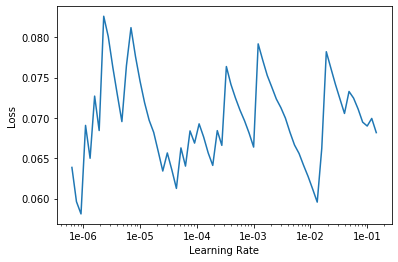

In [19]:
learn.recorder.plot()

find a lr from the plot, where the slop is the sharpest, downward! try to find something safe! not something between 2 points that are accidentally like that! This plot is actually not similar to what Jeremy showed in the lectures, but I guess something around 2e-05 to 4e-05 is the best according to this plot. Then do the unfreez and a few more epochs of training
```python 
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(2e-5, 4e-5))
```

## Find AUCROC for validation set

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
get_pred_results_valid=learn.get_preds(DatasetType.Valid)
preds_valid, y_valid= get_pred_results_valid
preds_valid_df=pd.DataFrame(preds_valid.numpy())

In [ ]:
preds_valid_df.columns=['benign_prob', 'malignant_prob']

In [ ]:
preds_valid.size()

In [ ]:
len(learn.data.valid_ds.items)#[0:18928] sometimes these two sizes are not the same for validation set 
#(in fastai, because it only does complete batches)

In [ ]:
preds_valid_df['FileName']=data.valid_ds.items #[0:18928]

In [ ]:
preds_valid_df['image_name']= preds_valid_df.apply(lambda row: os.path.basename(row['FileName']), axis=1) 
preds_valid_df['image_name']= preds_valid_df.apply(lambda row: row['image_name'][0:len(row['image_name'])-4], axis=1) 

In [ ]:
results=df.set_index('image_name').join(preds_valid_df.set_index('image_name'), how='inner')[['target', 'malignant_prob']]

In [ ]:
roc_auc_score(results['target'], results['malignant_prob'])

## find predictions for test set and make the submission file
assuming that test.csv and test images are copied to the instance storage

In [ ]:
fnames = get_image_files('path/test')
df_test=pd.read_csv('path/test/test.csv')
df_test.loc[:, 'file_name']= df_test.loc[:,'image_name']+'.jpg'
test_data = ImageList.from_df(df_test, path=path/'test', cols='file_name')
data.add_test(test_data)

In [ ]:
get_pred_results_test=learn.get_preds(DatasetType.Test)
preds_test, y_test= get_pred_results_test
preds_test_df=pd.DataFrame(preds_test.numpy())
preds_test_df['FileName']=data.test_ds.items
preds_test_df['image_name']= preds_test_df.apply(lambda row: os.path.basename(row['FileName']), axis=1) 
preds_test_df['image_name']= preds_test_df.apply(lambda row: row['image_name'][0:len(row['image_name'])-4], axis=1) 
submission_df= preds_test_df.loc[:, ['image_name', 1]]
submission_df.columns=['image_name', 'target']
submission_df.set_index('image_name', drop=True, inplace=True)
submission_df.loc[:,'target']=round(submission_df['target'], 4)
submission_df.to_csv('path/my_submission.csv')